## Prototype Selection for Nearest Neighbor

#### Yashowardhan Shinde - A69027295

### Idea:
Choosing effective prototypes for nearest neighbor classification involves selecting a subset of training examples that can represent the underlying distribution well. Here are some strategies and properties to consider:

### Strategies for Choosing Prototypes:

A good dataset for classification task should have carachteristics like diversity, density and class disribution. To make a good classification dataset we can use these factors and decide a simple sample selection strategy.

1. **Diversity:** Select prototypes that cover different regions of the input space. This helps capture the variability in the data distribution.

2. **Density:** Emphasize regions of higher data density, as these are likely to be more representative of the overall distribution.

3. **Class Distribution:** Maintain a balanced representation of different classes to avoid biasing the classifier towards dominant classes.

### Formalization and Automatic Selection:

Taking into consideration the strategies proposed above it becomes prominent that we can use a clustering algorithm for our selection. A clustering algorithm like K-Mean Clustering can find regions with high density and good separation in the dataset. This can help us realise higher density clusters within our dataset and then, for class distribution we can then do a nearest neighbor selection of equal number of points from each of the identified clusters. 

In [3]:
import numpy as np
import pandas as pd
import pickle as pkl
import random
from sklearn.cluster import KMeans
from scipy.stats import entropy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import seaborn as sns
import json

/Users/yashowardhanshinde/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Normalize Data

In [4]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root="MNIST", train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)

test_dataset = MNIST(root="MNIST", train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

In [5]:
train_images, train_labels = next(iter(train_dataloader))
flattened_train_images = train_images.view(train_images.size(0), -1).numpy()

In [6]:
test_images, test_labels = next(iter(test_dataloader))
flattened_test_images = test_images.view(test_images.size(0), -1).numpy()

### 1 Nearest Neighbor Function

In [7]:
def nearest_neighbor(train_data, test_data):
    """
    Performs k-nearest neighbor classification on the given train and test data.

    Parameters:
    - train_data: array-like, shape (n_samples, n_features)
        A tuple containing the training features and labels (x_train, y_train).
    - test_data: list
        A tuple containing the test features and labels (x_test, y_test).

    Returns:
    - accuracy: float
        Accuracy of the k-nearest neighbor classifier on the test data.

    Example:
    >>> x_train = np.array([[1, 2], [2, 3], [3, 4]])
    >>> y_train = [0, 1, 0]
    >>> x_test = np.array([[1, 1], [2, 2]])
    >>> y_test = [0, 1]
    >>> accuracy = nearest_neighbor((x_train, y_train), (x_test, y_test))
    >>> print(accuracy)
    1.0
    """
    k_value = 1
    knn_classifier = KNeighborsClassifier(n_neighbors=k_value)

    x_train, y_train = train_data
    x_test, y_test = test_data
    # Train the classifier on the training data
    knn_classifier.fit(x_train, y_train)

    # Make predictions on the test data
    y_pred = knn_classifier.predict(x_test)

    # Evaluate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


## Method 0:

### Random Data Selection

In [40]:
samples = [500, 1000, 2000, 5000, 10000, 20000, 30000]
seeds = [42, 64, 72, 101, 32, 1, 11, 53, 84, 27]
results = {
    "samples": [],
    "accuracy": [],
    "max": [],
    "min": []
}
for s in samples:
    total_acc = []
    for seed in seeds:
        np.random.seed(seed)
        train_indexes = np.random.randint(0, 60000, s)
        train = (flattened_train_images[train_indexes], train_labels[train_indexes])
        test = (flattened_test_images, test_labels)
        accuracy = nearest_neighbor(train, test)*100
        total_acc.append(accuracy)
    
    avg_acc = sum(total_acc)/len(seeds)
    max_acc = max(total_acc)
    min_acc = min(total_acc)
    print(f"Samples = {s} | Accuracy = {avg_acc}")
    results["samples"].append(s)
    results["accuracy"].append(avg_acc)
    results["max"].append(max_acc)
    results["min"].append(min_acc)

df = pd.DataFrame(results)
json_data = df.to_dict(orient='index')
with open("Results/random_sampling_results.json", "w") as file:
    json.dump(json_data, file, indent=2)

Samples = 500 | Accuracy = 85.03
Samples = 1000 | Accuracy = 88.496
Samples = 2000 | Accuracy = 91.162
Samples = 5000 | Accuracy = 93.554
Samples = 10000 | Accuracy = 94.825
Samples = 20000 | Accuracy = 95.594
Samples = 30000 | Accuracy = 95.97


## Method 1

#### Regular Clustering Based Selection:
K-Means Clustering is a popular unsupervised machine learning algorithm used for partitioning a dataset into K distinct, non-overlapping subsets (clusters).

This algorithm selects prototypes based on the K-Means clustering, ensuring diversity and density-based representation. Here we simply run a KMeans model with different cluster values and select equal number of points from each cluster.

In [8]:
def select_prototypes_clustering(X, data_points, clusters = 10, save = None, pretrained=False, pretrained_path = None):
    """
    Selects prototypes from the input data using K-Means clustering.

    Parameters:
    - X: array-like, shape (n_samples, n_features)
        The input data.
    - data_points: int
        Total number of data points to be selected as prototypes.
    - clusters: int, optional (default=10)
        Number of clusters to be used in K-Means clustering.
    - save: str or None, optional (default=None)
        File path to save the trained KMeans model if pretrained is False.
    - pretrained: bool, optional (default=False)
        If True, uses a pretrained KMeans model loaded from pretrained_path.
    - pretrained_path: str or None, optional (default=None)
        File path to the pretrained KMeans model if pretrained is True.

    Returns:
    - prototypes: list
        List of indices representing the selected prototypes.

    """
    
    # Step 1: Apply K-Means clustering
    if pretrained:
        with open(pretrained_path, "rb") as file:
            kmeans = pkl.load(file)
        clusters = len(kmeans.cluster_centers_)
    else:
        kmeans = KMeans(n_clusters=clusters, random_state=42)
        kmeans.fit(X)
        if save is not None:
            with open(save, "wb") as file:
                pkl.dump(kmeans, file)
            
    point_per_cluster = data_points//clusters
    # Step 2: Choose one representative from each cluster as a prototype
    prototypes = []
    for cluster_center in kmeans.cluster_centers_:
        # Find the nearest data point to the cluster center
        closest_point_idx = np.argsort(np.linalg.norm(X - cluster_center, axis=1))[:point_per_cluster]
        prototypes.extend(closest_point_idx)
    
    return prototypes


In [34]:
samples = [500, 1000, 2000, 5000, 10000, 20000, 30000]
clusters = [10, 50, 100, 150, 200, 250]
results = {
    "clusters": [],
    "samples": [],
    "accuracy": []
}
for k in clusters:
    for s in samples:
        # For the first time we will need to train a kmeans model that time 
        # pretrained = False, save = path_to_save_file
        train_indexes = select_prototypes_clustering(flattened_train_images, s, pretrained=True, pretrained_path=f"Models/kmeans_{k}.pkl")
        train = (flattened_train_images[train_indexes], train_labels[train_indexes])
        test = (flattened_test_images, test_labels)
        accuracy = nearest_neighbor(train, test)*100
        print(f"K = {k} | Samples = {s} | Accuracy = {accuracy}")
        results["clusters"].append(k)
        results["samples"].append(s)
        results["accuracy"].append(accuracy)
    print("=*=*"*50)

df = pd.DataFrame(results)
json_data = df.to_dict(orient='index')
with open("Results/cluster_sampling_results.json", "w") as file:
    json.dump(json_data, file, indent=2)

K = 10 | Samples = 500 | Accuracy = 69.64
K = 10 | Samples = 1000 | Accuracy = 74.08
K = 10 | Samples = 2000 | Accuracy = 76.18
K = 10 | Samples = 5000 | Accuracy = 81.72
K = 10 | Samples = 10000 | Accuracy = 85.83
K = 10 | Samples = 20000 | Accuracy = 89.72
K = 10 | Samples = 30000 | Accuracy = 92.42
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
K = 50 | Samples = 500 | Accuracy = 84.02
K = 50 | Samples = 1000 | Accuracy = 85.61999999999999
K = 50 | Samples = 2000 | Accuracy = 87.64
K = 50 | Samples = 5000 | Accuracy = 90.03999999999999
K = 50 | Samples = 10000 | Accuracy = 91.64
K = 50 | Samples = 20000 | Accuracy = 93.01
K = 50 | Samples = 30000 | Accuracy = 94.01
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=

### Compare Method 1 with Random Sampling

In [8]:
cluster_results = pd.read_json("Results/cluster_sampling_results.json")
random_results = pd.read_json("Results/random_sampling_results.json")
cluster_results = cluster_results.T
random_results = random_results.T
random_results["error"] = (random_results["max"] - random_results["min"])/2
samples = [500, 1000, 2000, 5000, 10000, 20000, 30000]
clusters = [10, 50, 100, 150, 200, 250]

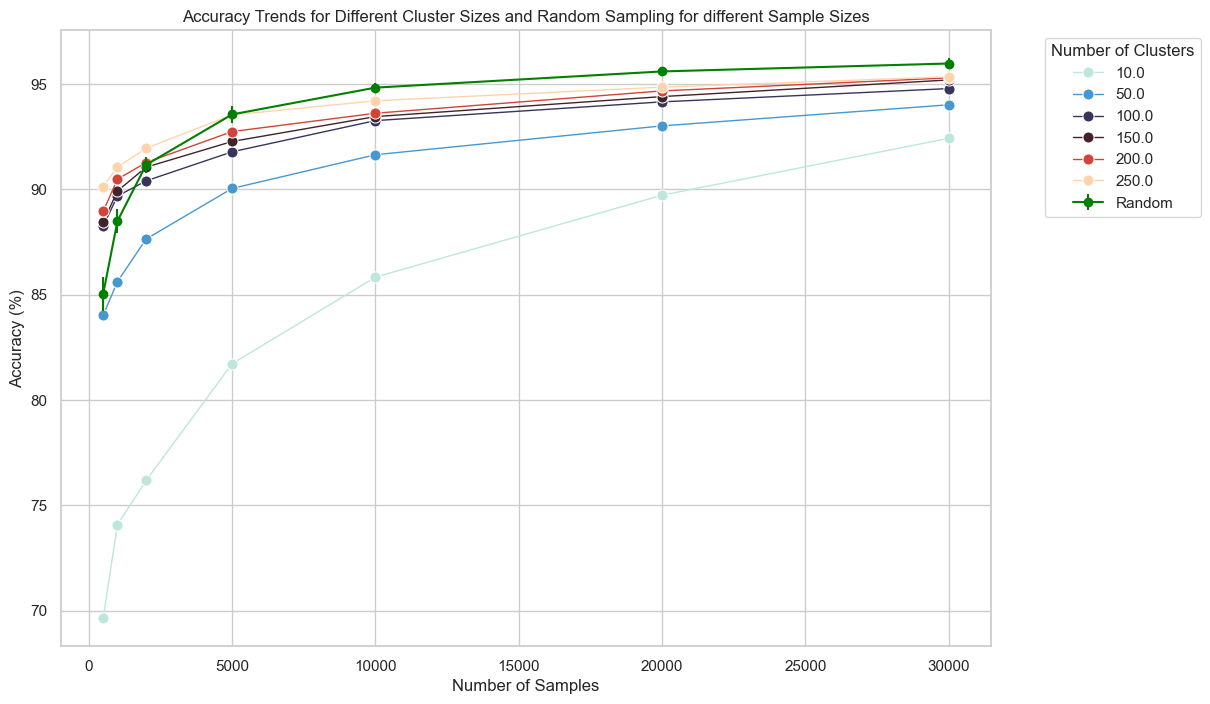

In [24]:
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=cluster_results, x="samples", 
             y="accuracy", 
             hue="clusters", 
             marker="o", 
             markersize=8, 
             linewidth=1, 
             palette=sns.color_palette("icefire", as_cmap=True))

plt.errorbar(x=random_results["samples"], y=random_results["accuracy"], yerr=random_results["error"], color="green", marker="o", label="Random")

# Customize the plot
plt.title("Accuracy Trends for Different Cluster Sizes and Random Sampling for different Sample Sizes")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.legend(title="Number of Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

## Method 2: 

### Classwise Clustering Based Selection

1. Convert Dataset into 10 parts - (each part corresponds to a class)
2. Select P = N//10 points from each part
2. Run k means clustering on each part
3. Select Q = P//k points closest to each cluster

In [9]:
def partition_data(train_data_labels):
    """
    Partitions the training data labels into chunks based on unique labels.

    Parameters:
    - train_data_labels: np.ndarray
        Array containing the labels of the training data.

    Returns:
    - chunks: list
        A list of subsets where each subset contains indices corresponding to a unique label.
    """
    
    chunks = list()
    for i in range(10):
        subset = np.where(train_data_labels == i)
        chunks.append(subset)
    return chunks

def select_prototypes_class_clustering(X, partitions, data_points, clusters):
    """
    Selects prototypes using classwise clustering.

    Parameters:
    - X: np.ndarray
        Array containing the data points.
    - partitions: list
        A list of subsets where each subset contains indices corresponding to a unique label.
    - data_points: int
        Total number of data points to be selected.
    - clusters: int
        Number of clusters to be used in K-Means clustering.

    Returns:
    - prototypes: list
        A list of indices representing the selected prototypes.

    """
    
    prototypes = list()
    point_per_cluster = data_points//(len(partitions)*clusters)
    
    for part in partitions:
        x = X[part]
        # Step 1: Apply K-Means clustering
        kmeans = KMeans(n_clusters=clusters, random_state=42)
        kmeans.fit(x)
                
        # Step 2: Choose representatives from each cluster as a prototype
        for cluster_center in kmeans.cluster_centers_:
            # Find the nearest data point to the cluster center
            closest_point_idx = np.argsort(np.linalg.norm(x - cluster_center, axis=1))[:point_per_cluster]
            # As the indices of the subset are not same as the dataset - extract indices for the dataset
            selected_indices = np.array(part[0])[closest_point_idx]
            prototypes.extend(selected_indices)

    return prototypes

In [10]:
samples = [500, 1000, 2000, 5000, 10000, 20000, 30000]
clusters = [1, 5, 10, 15, 20, 25]
partitions = partition_data(train_labels)
results = {
    "clusters": [],
    "samples": [],
    "accuracy": []
}
for k in clusters:
    for s in samples:
        train_indexes = select_prototypes_class_clustering(flattened_train_images, partitions, s, k)
        train = (flattened_train_images[train_indexes], train_labels[train_indexes])
        test = (flattened_test_images, test_labels)
        accuracy = nearest_neighbor(train, test)*100
        print(f"K = {k} | Samples = {s} | Accuracy = {accuracy}")
        results["clusters"].append(k*10)
        results["samples"].append(s)
        results["accuracy"].append(accuracy)
    print("=*=*"*50)

df = pd.DataFrame(results)
json_data = df.to_dict(orient='index')
with open("Results/classwise_cluster_sampling_results.json", "w") as file:
    json.dump(json_data, file, indent=2)

K = 1 | Samples = 500 | Accuracy = 76.98
K = 1 | Samples = 1000 | Accuracy = 79.13
K = 1 | Samples = 2000 | Accuracy = 80.36999999999999
K = 1 | Samples = 5000 | Accuracy = 83.99
K = 1 | Samples = 10000 | Accuracy = 87.1
K = 1 | Samples = 20000 | Accuracy = 90.12
K = 1 | Samples = 30000 | Accuracy = 92.56
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
K = 5 | Samples = 500 | Accuracy = 87.72999999999999
K = 5 | Samples = 1000 | Accuracy = 88.84
K = 5 | Samples = 2000 | Accuracy = 90.16
K = 5 | Samples = 5000 | Accuracy = 91.71000000000001
K = 5 | Samples = 10000 | Accuracy = 92.80000000000001
K = 5 | Samples = 20000 | Accuracy = 93.97
K = 5 | Samples = 30000 | Accuracy = 94.85
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*

### Compare Method 2 with Random Sampling

In [11]:
class_cluster_results = pd.read_json("Results/classwise_cluster_sampling_results.json")
class_cluster_results = class_cluster_results.T

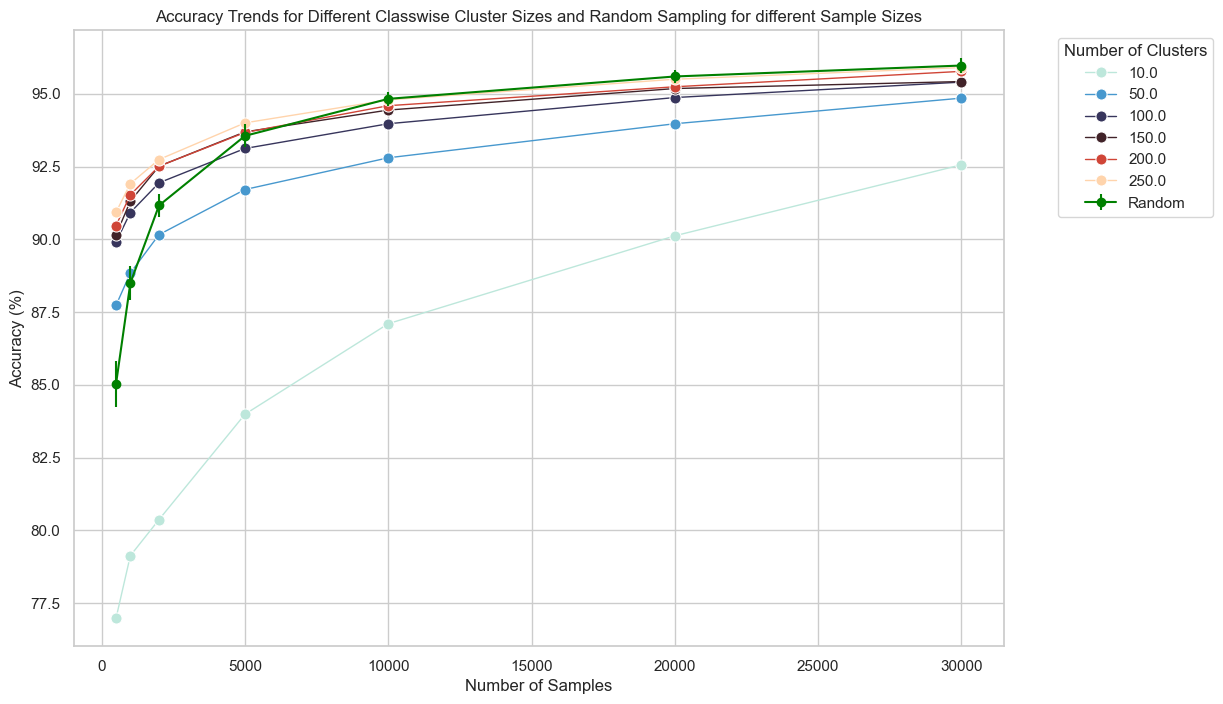

In [12]:
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=class_cluster_results, x="samples", 
             y="accuracy", 
             hue="clusters", 
             marker="o", 
             markersize=8, 
             linewidth=1, 
             palette=sns.color_palette("icefire", as_cmap=True))

plt.errorbar(x=random_results["samples"], y=random_results["accuracy"], yerr=random_results["error"], color="green", marker="o", label="Random")

# Customize the plot
plt.title("Accuracy Trends for Different Classwise Cluster Sizes and Random Sampling for different Sample Sizes")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.legend(title="Number of Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

## Method 3:

### Spatially Diverse Data Selection

Select n most diverse data points from the given dataset. Using the pairwise distance metric to calculate the distance between each pair of data points and then select the 'n' data points with the highest distances.

In [24]:
def pdist(X):
    """
    Computes the pairwise Euclidean distances between data points in X.

    Parameters:
    - X: np.ndarray
        Array containing the data points.

    Returns:
    - distances: np.ndarray
        Array containing pairwise Euclidean distances between data points.
    """
    # Get the number of observations
    n = X.shape[0]

    # Initialize the distance matrix
    distances = np.zeros((n * (n - 1)) // 2, dtype=np.double)

    # Compute pairwise distances
    k = 0
    for i in range(0, n - 1):
        for j in range(i + 1, n):
            distances[k] = np.linalg.norm(X[i] - X[j])
            k += 1

    return distances

def select_prototypes_spatial_diverse_data(dist_matrix, max_samples: int):
    """
    Selects prototypes from a spatially diverse dataset based on dissimilarity.

    Parameters:
    - dist_matrix: np.ndarray
        Matrix containing pairwise distances between data points.
    - max_samples: int
        Maximum number of prototypes to be selected.

    Returns:
    - selected_indices: list
        A list of indices representing the selected prototypes.

    """
    
    # Find indices of 'n' most dissimilar data points
    indices = np.unravel_index(np.argsort(dist_matrix, axis=None)[-max_samples:], dist_matrix.shape)
    selected_indices = list(set(indices[0]))
    return selected_indices

In [25]:
samples = [500, 1000, 2000, 5000, 10000, 20000, 30000]
results = {
    "samples": [],
    "accuracy": []
}

# Calculate pairwise distances
distances = pdist(flattened_test_images)
# Convert distances to a square distance matrix
dist_matrix = squareform(distances)

for s in samples:
    train_indexes = select_prototypes_spatial_diverse_data(dist_matrix, s)
    train = (flattened_train_images[train_indexes], train_labels[train_indexes])
    test = (flattened_test_images, test_labels)
    accuracy = nearest_neighbor(train, test)*100
    print(f"Samples = {s} | Accuracy = {accuracy}")
    results["samples"].append(s)
    results["accuracy"].append(accuracy)
    print("=*=*"*50)

df = pd.DataFrame(results)
json_data = df.to_dict(orient='index')
with open("Results/spatial_diverse_sampling_results.json", "w") as file:
    json.dump(json_data, file, indent=2)

Samples = 500 | Accuracy = 80.15
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Samples = 1000 | Accuracy = 83.49
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Samples = 2000 | Accuracy = 87.09
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Samples = 5000 | Accuracy = 90.14999999999999
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Samples = 10000 | Accuracy = 91.88
=*=*=*=*=*=*=*

### Compare Method 3 with Random Sampling

In [18]:
spatial_results = pd.read_json("Results/spatial_diverse_sampling_results.json")
spatial_results = spatial_results.T

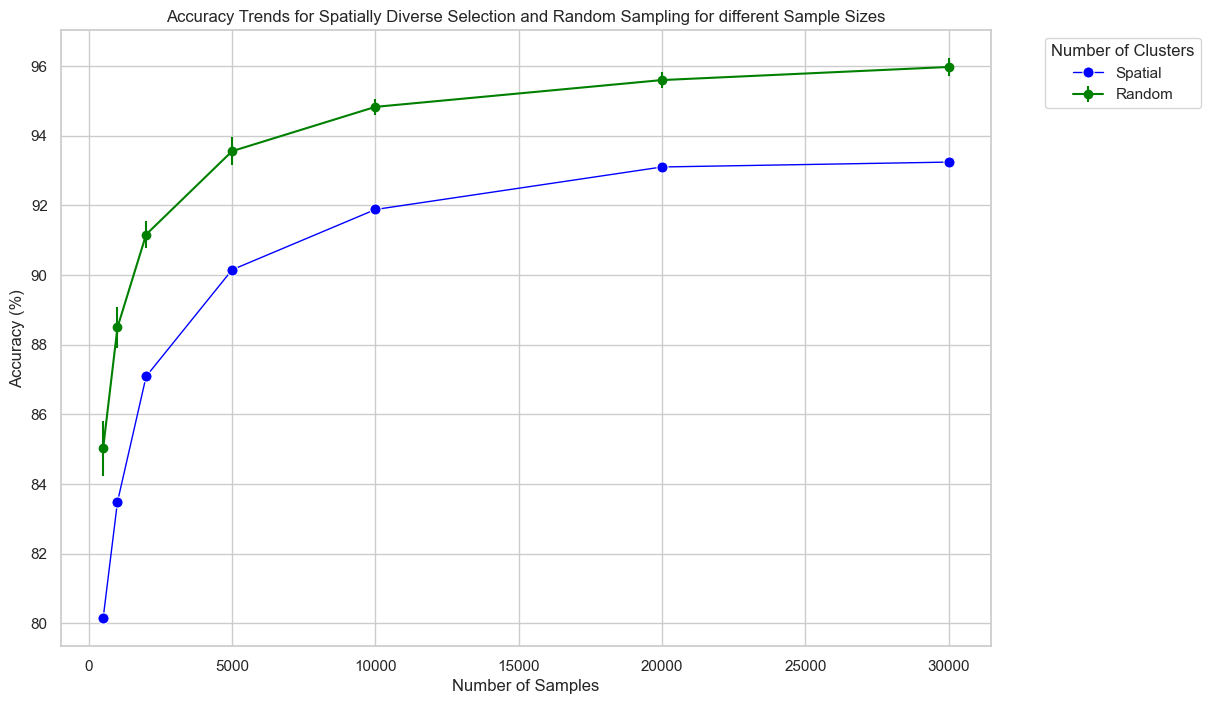

In [20]:
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=spatial_results, x="samples", 
             y="accuracy", 
             label="Spatial",
             marker="o", 
             markersize=8, 
             linewidth=1, 
             color="blue")
plt.errorbar(x=random_results["samples"], y=random_results["accuracy"], yerr=random_results["error"], color="green", marker="o", label="Random")

# Customize the plot
plt.title("Accuracy Trends for Spatially Diverse Selection and Random Sampling for different Sample Sizes")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.legend(title="Number of Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

## Method 4:

### Entropy Based Selection

```
Select 10% of total points to be selected randomly
    for i in range(10):
        train a knn on selected data
        calc metrics for prediction on test data
        run inference of this model on remaining train data
        calculate the entropy of all predictions of train data
        select the N//10 datapoints with lowest entropy
```


In [6]:
def calc_entropy(softmax_values):
    """
    Calculates the entropy of softmax probability values.

    Parameters:
    - softmax_values: np.ndarray
        Array containing softmax probability values.

    Returns:
    - entropy_values: np.ndarray
        Array containing entropy values.

    """
    return entropy(softmax_values, axis=1)

def select_entropy(unlabeled_pool, entropy_scores, n_rec):
    """
    Selects samples with minimum entropy from an unlabeled pool.

    Parameters:
    - unlabeled_pool: list
        List of indices representing unlabeled data points.
    - entropy_scores: np.ndarray
        Array containing entropy scores for each data point.
    - n_rec: int
        Number of records to select.

    Returns:
    - selected_indices: list
        List of indices representing the selected data points.

    """
    
    # Select samples with minimum entropy
    records = list(zip(unlabeled_pool, entropy_scores))
    records.sort(key= lambda x: x[1])
    return [rec[0] for rec in records[:n_rec]]

def update_nonselected_pool(selected, unlabeled_pool):
    """
    Updates the unlabeled pool by removing selected samples.

    Parameters:
    - selected: list
        List of indices representing selected data points.
    - unlabeled_pool: list
        List of indices representing unlabeled data points.

    Returns:
    - updated_pool: list
        Updated list of indices for the unlabeled pool.

    """
    return [x for x in unlabeled_pool if x not in selected]

def select_prototypes_entropy(train_images, train_labels, n_rec):
    """
    Selects prototypes using the entropy-based selection method.

    Parameters:
    - train_images: np.ndarray
        Array containing training images.
    - train_labels: np.ndarray
        Array containing training labels.
    - n_rec: int
        Number of records to select.

    Returns:
    - selected_pool: list
        List of indices representing selected prototypes.

    """
    
    # Set seed for reproducibility
    random.seed(42)
    selected_pool = random.sample(range(0, 60000), n_rec//10)
    nonselected_pool = [x for x in range(60000) if x not in selected_pool]
    
    for i in range(1, 10):
        # Train
        x_train = train_images[selected_pool]
        y_train = train_labels[selected_pool]
        
        knn = KNeighborsClassifier(n_neighbors=10)
        knn.fit(x_train, y_train)
        
        # Infer
        pred_probability = knn.predict_proba(flattened_train_images)
        uncertainty_scores = calc_entropy(pred_probability)
        
        selected = select_entropy(nonselected_pool, uncertainty_scores, n_rec//10)
        selected_pool.extend(selected)
        nonselected_pool = update_nonselected_pool(selected, nonselected_pool)

    return selected_pool

In [7]:
samples = [500, 1000, 2000, 5000, 10000, 20000, 30000]
results = {
    "samples": [],
    "accuracy": []
}

for s in samples:
    train_indexes = select_prototypes_entropy(flattened_train_images, train_labels, s)
    train = (flattened_train_images[train_indexes], train_labels[train_indexes])
    test = (flattened_test_images, test_labels)
    accuracy = nearest_neighbor(train, test)*100
    print(f"Samples = {s} | Accuracy = {accuracy}")
    results["samples"].append(s)
    results["accuracy"].append(accuracy)
    print("=*=*"*50)

df = pd.DataFrame(results)
json_data = df.to_dict(orient='index')
with open("Results/entropy_based_sampling_results.json", "w") as file:
    json.dump(json_data, file, indent=2)  

Samples = 500 | Accuracy = 84.5
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Samples = 1000 | Accuracy = 88.41
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Samples = 2000 | Accuracy = 91.2
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Samples = 5000 | Accuracy = 93.41000000000001
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Samples = 10000 | Accuracy = 94.86
=*=*=*=*=*=*=*=*

### Compare Method 4 with Random Sampling

In [21]:
entropy_results = pd.read_json("Results/entropy_based_sampling_results.json")
entropy_results = entropy_results.T

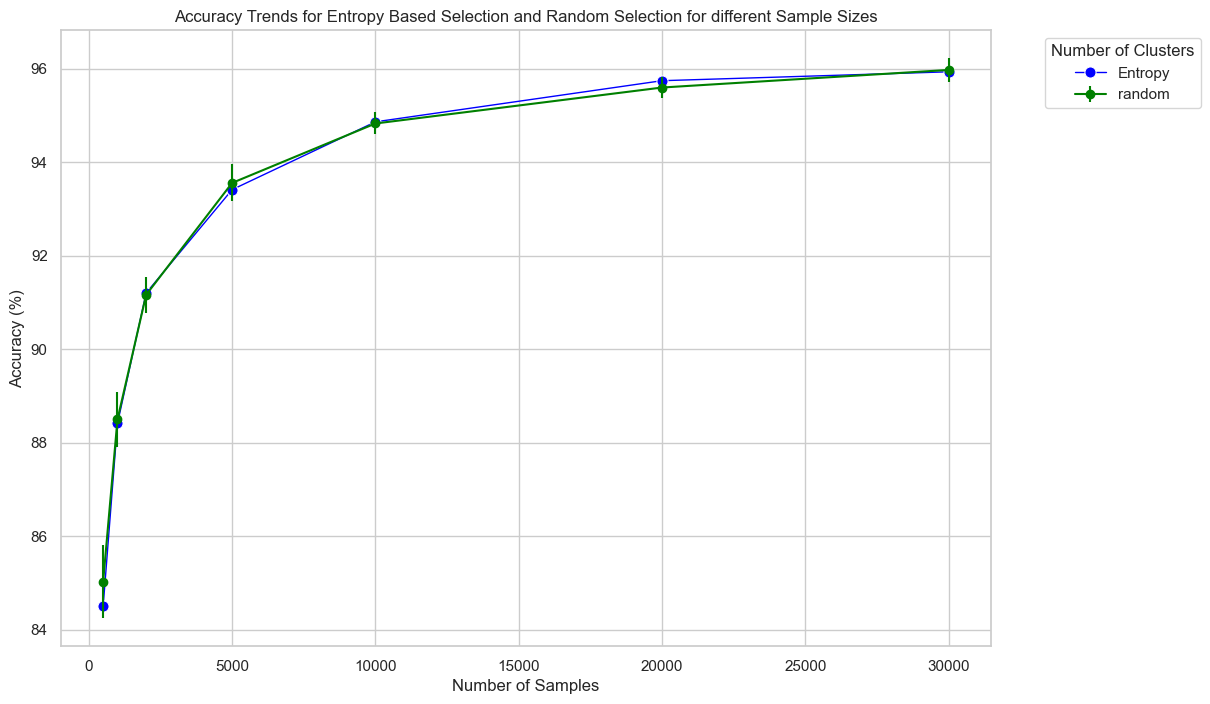

In [22]:
sns.set(style="whitegrid")

# Create a line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=entropy_results, x="samples", 
             y="accuracy", 
             label="Entropy",
             marker="o", 
             markersize=8, 
             linewidth=1, 
             color="blue")

plt.errorbar(x=random_results["samples"], y=random_results["accuracy"], yerr=random_results["error"], color="green", marker="o", label="random")

# Customize the plot
plt.title("Accuracy Trends for Entropy Based Selection and Random Selection for different Sample Sizes")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")
plt.legend(title="Number of Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()